In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from scipy import ndimage


# Extract Boundary

In [2]:
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt

def extract_ordered_boundary(mask, return_countor: bool=False):
    """
    Exclude the ordered boundary as list of tuples 

    Parameters:
    -----------
    mask: np.array ndim=2
        The binary mask
    
    return_countor: bool:
        Returns the float coordinates between pixels if True
        Returns the coordinates of the pixesl if False

    Retuens:
    --------
    ordered_boundary: list[tuple]
        coordinates of the boundary
    """
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        raise ValueError("Граница не найдена")
    
    # Если несколько контуров, берём самый длинный
    contour = max(contours, key=len)
    if return_countor:
        return contour

    # Переводим из (y, x) в (i, j) и округляем при необходимости
    ordered_boundary = [(int(round(y)), int(round(x))) for y, x in contour]
    ordered_boundary = [(y, x) for y, x in contour]
    ordered_boundary = []
    for y, x, in contour:
        if y%1 == 0:
            y, x = int(y), int(x)
            if not mask[y, x]:
                x += 1
        else:
            y, x = int(y), int(x)
            if not mask[y, x]:
                y += 1
        if (y, x) not in ordered_boundary:
            ordered_boundary.append((y, x))
    

    return ordered_boundary


# Direct Map
We need to define a continuous bijection $f: \mathbb{C}\to\mathbb{C}$ such that 
1. for number $z_0\in\mathbb{C}$ 
    $$
        f(z_0) = 0
    $$
2. for $n$ points $z_1, ..., z_n\in\mathbb{C}$
    $$
        f(e^{k\frac{2i\pi}{n}}) = z_k
    $$
    moreover
    $$
        f(e^{(k + t)\frac{2i\pi}{n}}) = (1 - t)\cdot z_k + t\cdot z_{k+1}
    $$
    where $t\in[0, 1]$ and $z_{n+1}:= z_1$

In [3]:
def get_bijection_defined_by_border(z0, zs):
    """
    Returns an approximate conformal bijection from the unit disk to
    the interior of the polygon with vertices zs, mapping 0 to z0.
    
    Parameters:
    -----------
    z0: complex
        The point where 0 should map.
    
    zs: np.array[complex]
        Polygon boundary points (z1 to zn), length n.
    
    Returns:
    --------
    f: function
        The complex-valued function f(z), defined for |z| <= 1.
    """
    zs = np.asarray(zs)
    n = len(zs)

    # Create interpolation along the unit circle
    angles = np.linspace(0, 2 * np.pi, num=n+1)
    points = np.append(zs, zs[0])  # close the loop
    
    # Parametrize by angle θ in [0, 2π)
    fx = interp1d(angles, points.real, kind='linear')
    fy = interp1d(angles, points.imag, kind='linear')

    def f(z):
        z = np.asarray(z)
        r = np.abs(z)
        theta = np.angle(z) % (2 * np.pi)

        # Linear interpolation on the boundary
        boundary_values = fx(theta) + 1j * fy(theta)

        # Radial interpolation from center to boundary
        return (1 - r) * z0 + r * boundary_values

    return f


In [4]:
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1


mask = ndimage.zoom(mask, (2, 2), order=1, grid_mode=True).astype(bool).astype(int)

center_x, center_y = np.argwhere(mask)[np.random.randint(mask.sum())]
z0 = center_x + 1j*center_y

boundary = extract_ordered_boundary(mask, return_countor=True)
boundary_x, boundary_y = np.transpose(boundary)

zs = boundary_x + 1j*boundary_y
z0, zs

/tmp/ipykernel_33971/2172033007.py:13: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  mask = ndimage.zoom(mask, (2, 2), order=1, grid_mode=True).astype(bool).astype(int)


(np.complex128(15+13j),
 array([28.5+18.j , 28.5+17.j , 28.5+16.j , 28.5+15.j , 28.5+14.j ,
        28.5+13.j , 28.5+12.j , 28.5+11.j , 28. +10.5j, 27. +10.5j,
        26.5+10.j , 26.5 +9.j , 26.5 +8.j , 26.5 +7.j , 26.5 +6.j ,
        26.5 +5.j , 26.  +4.5j, 25.  +4.5j, 24.5 +4.j , 24.5 +3.j ,
        24.  +2.5j, 23.  +2.5j, 22.  +2.5j, 21.  +2.5j, 20.5 +3.j ,
        20.5 +4.j , 20.  +4.5j, 19.  +4.5j, 18.  +4.5j, 17.  +4.5j,
        16.  +4.5j, 15.  +4.5j, 14.5 +5.j , 14.5 +6.j , 14.  +6.5j,
        13.  +6.5j, 12.  +6.5j, 11.  +6.5j, 10.5 +6.j , 10.5 +5.j ,
        10.  +4.5j,  9.  +4.5j,  8.5 +4.j ,  8.5 +3.j ,  8.  +2.5j,
         7.  +2.5j,  6.  +2.5j,  5.  +2.5j,  4.5 +3.j ,  4.5 +4.j ,
         4.  +4.5j,  3.  +4.5j,  2.5 +5.j ,  2.5 +6.j ,  2.5 +7.j ,
         2.5 +8.j ,  2.5 +9.j ,  2.5+10.j ,  2.5+11.j ,  2.5+12.j ,
         3. +12.5j,  4. +12.5j,  4.5+13.j ,  4.5+14.j ,  4.5+15.j ,
         4.5+16.j ,  4.5+17.j ,  4.5+18.j ,  5. +18.5j,  6. +18.5j,
         6.5+19.j ,  6.5

In [5]:
z_input = np.zeros(mask.shape, dtype=complex)
#z_input[mask == 0] = None
z_input = np.arange(mask.shape[1]).reshape(1, -1) + 1j*np.arange(mask.shape[0]).reshape(-1, 1)


In [6]:
f = get_bijection_defined_by_border(z0, zs)
f_inv = lambda z: np.nan*z

z_output = f(z_input)
z_output_inv = f_inv(z_input)


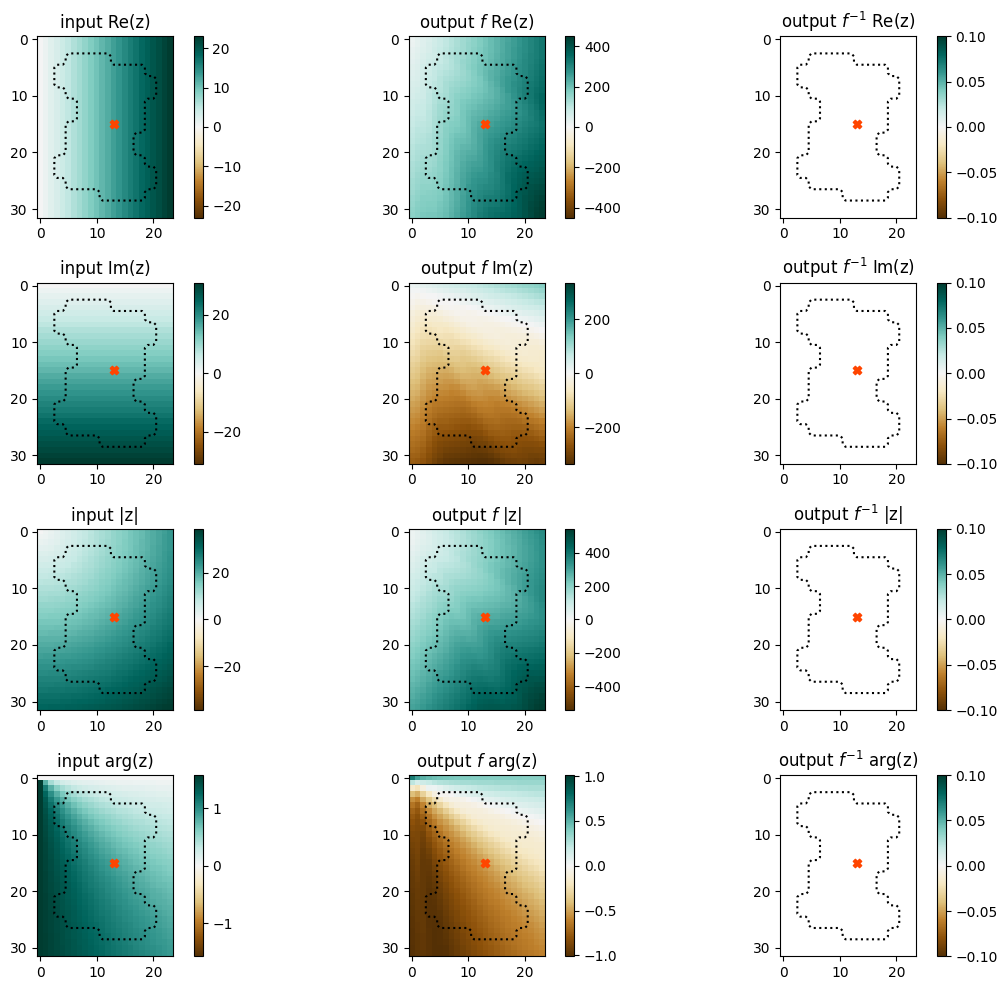

In [7]:
fig, axs = plt.subplots(4, 3, figsize=(12, 10))
representations = {
    'Re(z)': lambda z: z.real, 
    'Im(z)': lambda z: z.imag, 
    '|z|': lambda z: np.abs(z), 
    'arg(z)': lambda z: np.angle(z), 
}
for i_col, (z, title) in enumerate(zip([z_input, z_output, z_output_inv], ['input', 'output $f$', 'output $f^{-1}$'])):
    for i_row, (key, rep) in enumerate(representations.items()):

        img = rep(z)
        vmax = np.max(abs(img))
        vmin = -np.max(abs(img))
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        axs[i_row, i_col].set_title(f'{title} {key}')

        sm = axs[i_row, i_col].imshow(img, cmap='BrBG', norm=norm)
        plt.colorbar(sm, ax=axs[i_row, i_col])
        axs[i_row, i_col].scatter(center_y, center_x, color='orangered', marker='X')
        axs[i_row, i_col].plot(boundary_y, boundary_x, color='black', linestyle=':')
plt.tight_layout()
plt.show()

# Combinatorial Way

In [8]:
import networkx as nx
import pandas as pd

from tqdm import tqdm

/tmp/ipykernel_33971/1790754282.py:13: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  mask = ndimage.zoom(mask, (3, 3), order=1, grid_mode=True).astype(bool).astype(int)


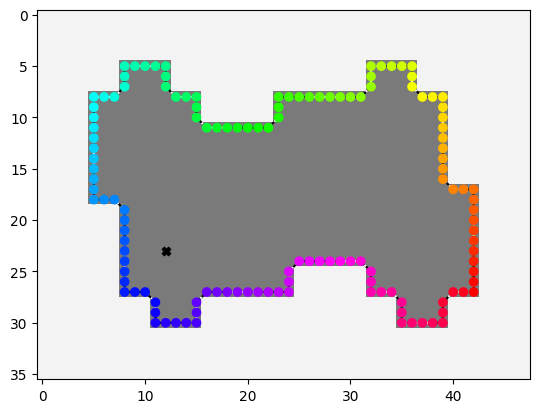

In [20]:
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1


mask = ndimage.zoom(mask, (3, 3), order=1, grid_mode=True).astype(bool).astype(int)

center_x, center_y = np.argwhere(mask)[np.random.randint(mask.sum())]

boundary = extract_ordered_boundary(mask, return_countor=False)
boundary_x, boundary_y = np.transpose(boundary)
boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi


fig, ax = plt.subplots(1, 1)
ax.imshow(np.transpose(mask), cmap='Greys', vmin=-0.2, vmax=1.8, zorder=0)

ax.plot(boundary_x, boundary_y, color='black', linestyle='-', zorder=1)
ax.plot(boundary_x, boundary_y, color='white', linestyle=':', zorder=1)
ax.scatter(boundary_x, boundary_y, c=plt.get_cmap('hsv')(boundary_angles/(2*np.pi)), zorder=2)

ax.scatter(center_x, center_y, color='black', marker='X', zorder=3)
plt.show()

In [21]:
def get_graph_from_mask(mask) -> nx.Graph:
    """

    """
    mask = mask.astype(bool)
    edges_v = np.argwhere(mask[1:, :] & mask[:-1, :])
    edges_v = np.array([edges_v, edges_v + np.array([1, 0])])
    edges_v = edges_v.transpose((1, 0, 2))
    edges_v = [(tuple(node0), tuple(node1)) for node0, node1 in edges_v]

    edges_h = np.argwhere(mask[:, 1:] & mask[:, :-1])
    edges_h = np.array([edges_h, edges_h + np.array([0, 1])])
    edges_h = edges_h.transpose((1, 0, 2))
    edges_h = [(tuple(node0), tuple(node1)) for node0, node1 in edges_h]

    nodes = [tuple(node) for node in np.argwhere(mask)]

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges_h + edges_v)
    return g

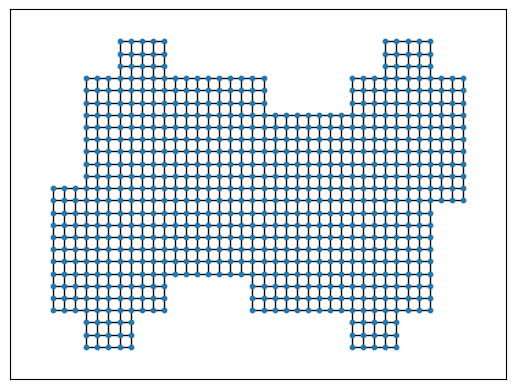

In [22]:
g = get_graph_from_mask(mask)
pos = {node: node for node in g.nodes}

nx.draw_networkx(g, pos=pos, with_labels=False, node_size=10)

In [23]:
def get_shortest_paths_to_boundary(g, source, boundary):
    """
    Returns the length of shortes path and the indices of coresponding targets
    """
    lengths = np.array([nx.shortest_path_length(g, source, target) for target in boundary])
    length_min = np.min(lengths)
    indices = np.argwhere(lengths == length_min)
    return length_min, indices

In [24]:
def get_node_info(g, center, boundary, boundary_angles=None, outer_path_to_center=None, 
                  border_value=2, border_multpplyer=0.67, max_iter=10, ) -> pd.DataFrame:
    """
    """
    if boundary_angles is None:
        boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi
    
    nodes_df = []
    for node in tqdm(g.nodes):
        if outer_path_to_center is None:
            path_to_center = nx.shortest_path_length(g, node, center)
        else:
            path_to_center = outer_path_to_center[node]

        path_to_border, boundary_index = get_shortest_paths_to_boundary(g, node, boundary)
        nodes_df.append({
            'node': node, 
            'path_to_center': path_to_center, 
            'path_to_border': path_to_border, 
            'boundary_index': boundary_index, 
        })
    nodes_df = pd.DataFrame(nodes_df)

    # radius_value
    nodes_df['radius_value'] = nodes_df['path_to_center']/(nodes_df['path_to_center'] + nodes_df['path_to_border'])
    nodes_df['radius_value'] = nodes_df['radius_value'].fillna(0)

    # angle value
    #nodes_df['angle_value'] = nodes_df['boundary_index'].apply(lambda indices: np.angle(np.prod(np.exp(1j*boundary_angles)[indices])**(1/np.prod(indices.shape))))
    nodes_df['angle_value'] = nodes_df['boundary_index'].apply(lambda indices: boundary_angles[indices[0][0]])

    # cords
    nodes_df['x'] = nodes_df['node'].apply(lambda node: node[0])
    nodes_df['y'] = nodes_df['node'].apply(lambda node: node[1])

    # set index
    nodes_df = nodes_df.set_index(nodes_df['node'])


    if max_iter <= 0:
        return nodes_df

    
    # define recursion
    next_nodes = nodes_df[nodes_df['path_to_center']*border_value <= nodes_df['path_to_border']]['node'].to_list()
    next_edges = [(e0, e1) for e0, e1 in g.edges() if (e0 in next_nodes) or (e1 in next_nodes)]
    next_graph = nx.Graph()
    next_graph.add_edges_from(next_edges)

    print(len(next_graph.nodes()), len(g.nodes()), len(next_graph.nodes()) == len(g.nodes()))
    if len(next_graph.nodes()) == len(g.nodes()):
        return nodes_df

    nodes_df.loc[next_nodes, 'angle_value'] = None    

    pos = {node: node for node in g.nodes()}
    cmap = plt.get_cmap()
    node_colors = ['grey' if np.isnan(nodes_df['angle_value'][node]) else cmap(nodes_df['angle_value'][node]/(2*np.pi)) for node in g.nodes()]
    nx.draw_networkx(g, pos=pos, node_color=node_colors, with_labels=False)
    plt.show()
    
    next_boundary = [node for node in next_graph.nodes() if node not in next_nodes]
    next_boundary_angles = nodes_df['angle_value'][next_boundary].values

    next_nodes_df = get_node_info(next_graph, center, boundary=next_boundary, 
                                  boundary_angles=next_boundary_angles, 
                                  outer_path_to_center=nodes_df['path_to_center'], 
                                  border_value=border_value*border_multpplyer, border_multpplyer=border_multpplyer, 
                                  max_iter=max_iter - 1)
    
    nodes_df.loc[next_nodes_df.index, 'angle_value'] = next_nodes_df['angle_value']
    
    return nodes_df

In [25]:
def map_disc_to_unit(mask, center, boundary=None, boundary_angles=None):
    """
    """
    if boundary is None:
        boundary = extract_ordered_boundary(mask, return_countor=False)

    g = get_graph_from_mask(mask)
    
    nodes_df = get_node_info(g, center, boundary, boundary_angles)
    x = nodes_df['x'].values
    y = nodes_df['y'].values
    r_vals = nodes_df['radius_value'].values
    a_vals = nodes_df['angle_value'].values
    
    mask_r = np.nan*mask
    mask_r[x, y] = r_vals

    mask_a = np.nan*mask
    mask_a[x, y] = a_vals

    return mask_r, mask_a

  0%|          | 0/724 [00:00<?, ?it/s]

100%|██████████| 724/724 [00:26<00:00, 27.74it/s]

24 724 False


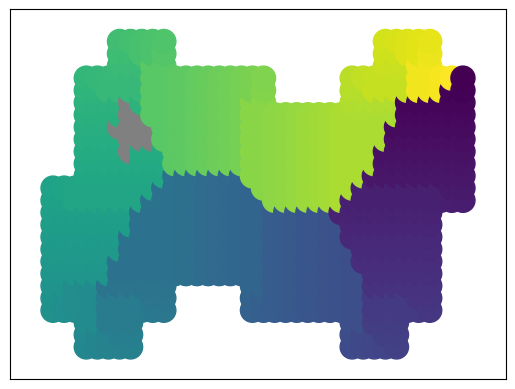

100%|██████████| 24/24 [00:00<00:00, 8346.87it/s]


8 24 False


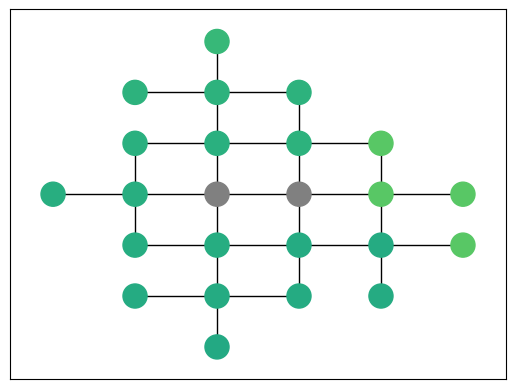

100%|██████████| 8/8 [00:00<00:00, 14952.96it/s]


8 8 True


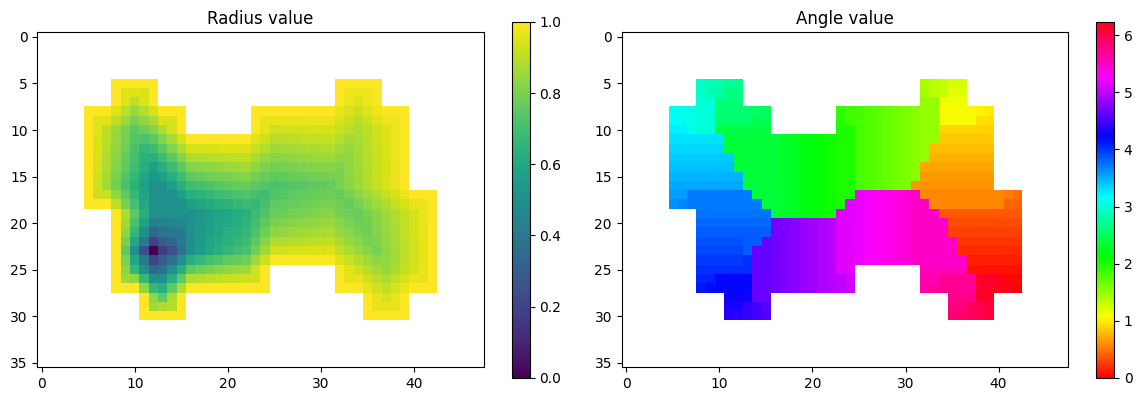

In [26]:
mask_r, mask_a = map_disc_to_unit(mask, (center_x, center_y), boundary)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Radius value')
sm0 = axs[0].imshow(np.transpose(mask_r), cmap='viridis')
plt.colorbar(sm0, ax=axs[0])
axs[1].set_title('Angle value')
sm1 = axs[1].imshow(np.transpose(mask_a), cmap='hsv')
plt.colorbar(sm1, ax=axs[1])

plt.tight_layout()
plt.show()

100%|██████████| 724/724 [00:26<00:00, 27.39it/s]

24 724 False


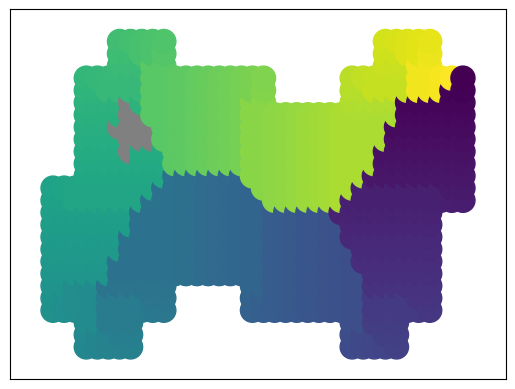

100%|██████████| 24/24 [00:00<00:00, 8181.35it/s]


8 24 False


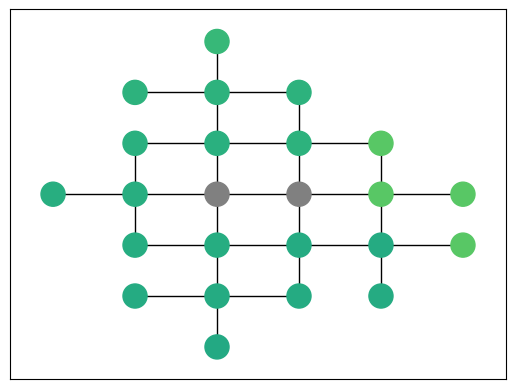

100%|██████████| 8/8 [00:00<00:00, 14544.62it/s]

8 8 True
nodes_df.shape = (724, 8)


,node,path_to_center,path_to_border,boundary_index,radius_value,angle_value,x,y
node,,,,,,,,
"(5, 8)","(5, 8)",22,0,[[67]],1.0,3.141593,5,8
"(5, 9)","(5, 9)",21,0,[[68]],1.0,3.188482,5,9
"(5, 10)","(5, 10)",20,0,[[69]],1.0,3.235372,5,10
"(5, 11)","(5, 11)",19,0,[[70]],1.0,3.282261,5,11
"(5, 12)","(5, 12)",18,0,[[71]],1.0,3.329150,5,12


In [27]:
nodes_df = get_node_info(g, (center_x, center_y), boundary)

print(f'nodes_df.shape = {nodes_df.shape}')
nodes_df.head()

In [28]:
nodes_df['angle_value'] = nodes_df['boundary_index'].apply(lambda indices: boundary_angles[indices[0][0]])

print(f'nodes_df.shape = {nodes_df.shape}')
nodes_df.head()

nodes_df.shape = (724, 8)


,node,path_to_center,path_to_border,boundary_index,radius_value,angle_value,x,y
node,,,,,,,,
"(5, 8)","(5, 8)",22,0,[[67]],1.0,3.141593,5,8
"(5, 9)","(5, 9)",21,0,[[68]],1.0,3.188482,5,9
"(5, 10)","(5, 10)",20,0,[[69]],1.0,3.235372,5,10
"(5, 11)","(5, 11)",19,0,[[70]],1.0,3.282261,5,11
"(5, 12)","(5, 12)",18,0,[[71]],1.0,3.329150,5,12


In [29]:
r_vals = nodes_df['radius_value'].values
a_vals = nodes_df['angle_value'].values

x = nodes_df['x'].values
y = nodes_df['y'].values

mask_r = np.nan*mask
mask_r[x, y] = r_vals

mask_a = np.nan*mask
mask_a[x, y] = a_vals

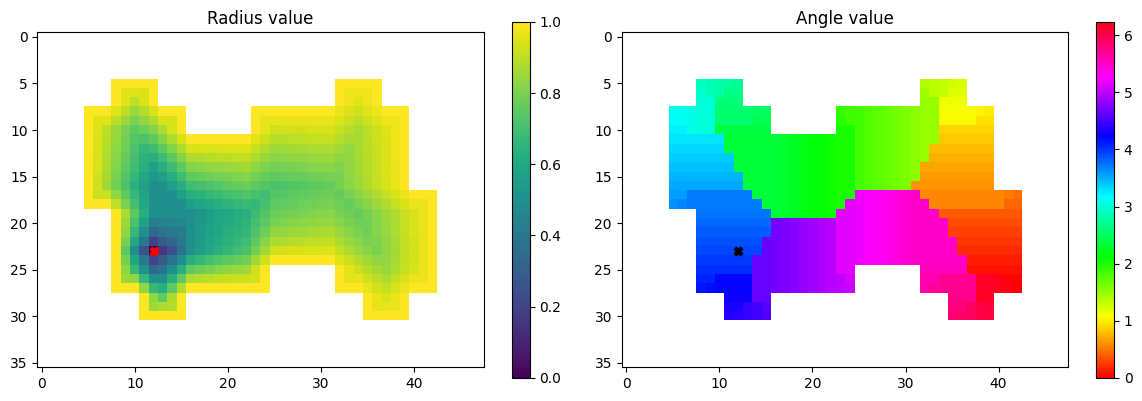

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Radius value')
sm0 = axs[0].imshow(np.transpose(mask_r), cmap='viridis')
plt.colorbar(sm0, ax=axs[0])
axs[1].set_title('Angle value')
sm1 = axs[1].imshow(np.transpose(mask_a), cmap='hsv')
plt.colorbar(sm1, ax=axs[1])

axs[0].scatter(center_x, center_y, color='red', marker='X')
axs[1].scatter(center_x, center_y, color='black', marker='X')

plt.tight_layout()
plt.show()